In [1]:
import os
%load_ext rpy2.ipython


In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'

nprocs = 20

In [3]:
%%R
library(ggplot2)
library(phyloseq)
library(tidyr)
library(plyr);library(dplyr)

library(scales)
library(biom)
library(metagenomeSeq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)

physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE) 
physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.Sparsity

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [5]:
%%R
physeq.Bulk.m = physeq.Bulk %>% sample_data

In [6]:
%%R
physeq.Bulk.m$Sample_Date = as.POSIXct(strptime(physeq.Bulk.m$Sample_Date, format = "%m/%d/%y"))
str(physeq.Bulk.m$Sample_Date)

 POSIXct[1:175], format: "2015-11-25" "2014-09-24" "2015-06-17" "2015-10-27" ...


In [7]:
%%R
physeq.Bulk.m$Day = round(difftime(physeq.Bulk.m$Sample_Date, min(physeq.Bulk.m$Sample_Date), 
         units = "days"))
tail(physeq.Bulk.m)

Sample Data:        [6 samples by 25 sample variables]:
                      Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Sept.NTH.2.2015   Sept.NTH.2.2015       NA    515f    806r      28  actcactg
Oct.PTR.3.2015     Oct.PTR.3.2015       NA    515f    806r      55  tagtctcc
Aug.NTR.4.2015     Aug.NTR.4.2015       NA    515f    806r      19  acgctact
Aug.NTH.3.2015     Aug.NTH.3.2015       NA    515f    806r      11  gacatagt
April.NTR.3.2015 April.NTR.3.2015       NA    515f    806r      94  tatagcga
Nov.NTH.4.2015     Nov.NTH.4.2015       NA    515f    806r      81  gtctatga
                 Fwd.index Treatment      Day Replicate Pool Land_Management
Sept.NTH.2.2015   ctgcgtgt      <NA> 440 days         2    8             NTH
Oct.PTR.3.2015    ggatatct      <NA> 474 days         3    8             PTR
Aug.NTR.4.2015    tagcgagt      <NA> 399 days         4    8             NTR
Aug.NTH.3.2015    tagcgagt      <NA> 399 days         3    8             NTH
April.NTR.3.2015  cg

In [8]:
%%R
physeq.Bulk.m$Day_rel = as.numeric(physeq.Bulk.m$Day)


In [9]:
%%R
physeq.final = merge_phyloseq(physeq.Bulk.Sparsity, physeq.Bulk.m)
physeq.final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [10]:
%%R
physeq.final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [11]:
%%R
make_metagenomeSeq = function(physeq) {
    require("metagenomeSeq")
    require("phyloseq")
    # Enforce orientation
    if (!taxa_are_rows(physeq)) {
        physeq <- t(physeq)
    }
    OTU = as(otu_table(physeq), "matrix")
    #OTUTill = subset(OTU, rownames(OTU) %in% df.Till.r$OTU)

    # Convert sample_data to AnnotatedDataFrame
    ADF = AnnotatedDataFrame(data.frame(sample_data(physeq)))
    # define dummy 'feature' data for OTUs, using their name Helps with
    # extraction and relating to taxonomy later on.
    TDF = AnnotatedDataFrame(data.frame(tax_table(physeq)))
    #TDFTill = subset(TDF, rownames(TDF) %in% df.Till.r$OTU)
    TDF$Rank9 = rownames(TDF)


    # Create the metagenomeSeq object
    MGS = newMRexperiment(counts = OTU, phenoData = ADF, featureData = TDF)
    # Trigger metagenomeSeq to calculate its Cumulative Sum scaling factor.
    MGS = cumNorm(MGS)
    return(MGS)
}

MR = make_metagenomeSeq(physeq.final)

In [12]:
%%R
str(MR)

Formal class 'MRexperiment' [package "metagenomeSeq"] with 8 slots
  ..@ expSummary       :<environment: 0x1110b710> 
  ..@ assayData        :<environment: 0x10face50> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  .. .. ..@ varMetadata      :'data.frame':	26 obs. of  1 variable:
  .. .. .. ..$ labelDescription: chr [1:26] NA NA NA NA ...
  .. .. ..@ data             :'data.frame':	175 obs. of  26 variables:
  .. .. .. ..$ Full.sample    : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  .. .. .. ..$ Fraction       : int [1:175] NA NA NA NA NA NA NA NA NA NA ...
  .. .. .. ..$ PrimerF        : Factor w/ 1 level "515f": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..$ PrimerR        : Factor w/ 1 level "806r": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..$ Barcode        : int [1:175] 84 145 84 46 122 125 159 62 2 181 ...
  .. .. .. ..$ Rev.index      : Factor w/ 12 levels "acgctact","actacgac",..: 8 10 8 6 3 3 5 5 4 8 ...
  .

In [13]:
%%R
TimeSeries = function(MR, feature) {  
    
    res = fitTimeSeries(obj = MR, lvl = 'Rank9', feature = feature, class = "Till",
                    id = "Full.sample", time = "Day_rel", log = TRUE)

    return(res)
}




In [11]:
%%R
OTU = as(otu_table(physeq.final), "matrix")

feature = rownames(OTU)
str(feature)

 chr [1:3964] "OTU.1739" "OTU.1813" "OTU.778" "OTU.2180" ...


In [ ]:
%%R 
##mdf %>% filter(OTU == 'OTU.99') %>% group_by(Sample_Date) %>% summarise(count = n())

In [17]:
%%R
grep('OTU.99', feature)


 [1]  188  834  931 1160 1884 2435 2455 2572 2607 2680 2755 2981 3329 3649 3806


In [12]:
%%R
feature = feature[-67] 
feature = feature[-252]

In [18]:
%%R
#OTUs not found across all timepoints?
registerDoParallel(20)

TS = llply(feature, 
          TimeSeries, 
          .parallel = TRUE,
          MR = MR 
         )

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWa

In [19]:
%%R
str(TS)

List of 3962
 $ :List of 5
  ..$ timeIntervals: chr "No statistically significant time intervals detected"
  ..$ data         :'data.frame':	175 obs. of  4 variables:
  .. ..$ abundance: num [1:175] 0 0 1.39 0 0 ...
  .. ..$ class    : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ time     : num [1:175] 503 76 342 474 0 0 111 474 399 139 ...
  .. ..$ id       : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  ..$ fit          :'data.frame':	504 obs. of  3 variables:
  .. ..$ fit       : num [1:504] 0.124 0.124 0.124 0.125 0.125 ...
  .. ..$ se        : num [1:504] 0.143 0.142 0.141 0.141 0.14 ...
  .. ..$ timePoints: num [1:504] 0 1 2 3 4 5 6 7 8 9 ...
  ..$ perm         : NULL
  ..$ call         : language fitTimeSeries(obj = MR, feature = feature, class = "Till", time = "Day_rel",      id = "Full.sample", lvl = "Rank9", log = TRUE)
 $ :List of 5
  ..$ timeIntervals: num [1, 1:4] 140 503 -103 0
  .. ..- attr(*, "dimnames")=List of 2
  .. 

In [20]:
%%R
names(TS) = feature

In [57]:
%%R
timeSeriesFits = sapply(TS,function(i){i[[1]]})[-grep("No",TS)]

In [40]:
%%R
str(timeSeriesFits)

List of 2700
 $ OTU.1813 : num [1, 1:4] 140 503 -103 0
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr "OTU.1813 interval:1"
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.778  : num [1, 1:4] 0 503 -317 0
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr "OTU.778 interval:1"
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.2180 : num [1, 1:4] 281 503 -55.057 0.024
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr "OTU.2180 interval:1"
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.2343 : num [1, 1:4] 0 503 178 0
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr "OTU.2343 interval:1"
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.1158 : num [1, 1:4] 15 398 110.174 0.006
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr "OTU.1158 interval:1"
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.23337: num [1, 1:4] 46 186 37.643 0.002
  ..- at

In [67]:
%%R
timeSeriesFits.Filt = timeSeriesFits[-1241]

In [68]:
%%R
for(i in 1:length(timeSeriesFits.Filt)){
    rownames(timeSeriesFits.Filt[[i]]) =
    paste(
    paste(names(timeSeriesFits.Filt)[i]," interval",sep=""),
    1:nrow(timeSeriesFits.Filt[[i]]),sep=":"
)
}

In [71]:
%%R
timeSeriesFits = as.data.frame(do.call(rbind, timeSeriesFits.Filt))


#do.call(rbind,timeSeriesFits)

In [72]:
%%R
timeSeriesFits = as.data.frame(do.call(rbind, timeSeriesFits.Filt))


#do.call(rbind,timeSeriesFits)

In [73]:
%%R
pvalues = timeSeriesFits[,"p.value"]
adjPvalues = p.adjust(pvalues,"bonferroni")
timeSeriesFits = cbind(timeSeriesFits,adjPvalues)
head(timeSeriesFits)

                     Interval start Interval end       Area p.value adjPvalues
OTU.1813 interval:1             140          503 -103.47545   0.000          0
OTU.778 interval:1                0          503 -316.80841   0.000          0
OTU.2180 interval:1             281          503  -55.05725   0.024          1
OTU.2343 interval:1               0          503  178.45419   0.000          0
OTU.1158 interval:1              15          398  110.17368   0.006          1
OTU.23337 interval:1             46          186   37.64298   0.002          1


In [74]:
%%R
write.csv(timeSeriesFits, 'data/timeSeries_tillage_all.csv')

In [13]:
%%R
TSTill = read.csv('data/timeSeries_tillage_all.csv')

In [14]:
%%R
filter(TSTill, X == 'OTU.10 interval:1')

                  X Interval.start Interval.end     Area p.value adjPvalues
1 OTU.10 interval:1            455          503 27.26851   0.035          1


In [26]:
%%R
TS.sig = filter(TSTill, adjPvalues <= 0.01)
length(TS.sig$X)

[1] 1540


In [27]:
%%R
TS.sig$OTU_interval = TS.sig$X
TS.sig = separate(TS.sig, OTU_interval, c('OTU', 'interval'), sep = " ") %>% separate(interval, c('interval', 'num'))
head(TS.sig)

                    X Interval.start Interval.end       Area p.value adjPvalues
1 OTU.1813 interval:1            140          503 -103.47545       0          0
2  OTU.778 interval:1              0          503 -316.80841       0          0
3 OTU.2343 interval:1              0          503  178.45419       0          0
4 OTU.1809 interval:1            234          503  -67.29953       0          0
5 OTU.2014 interval:1             92          469   73.01350       0          0
6  OTU.598 interval:1             43          503  236.57720       0          0
       OTU interval num
1 OTU.1813 interval   1
2  OTU.778 interval   1
3 OTU.2343 interval   1
4 OTU.1809 interval   1
5 OTU.2014 interval   1
6  OTU.598 interval   1


In [19]:
%%R
print(length(unique(TS.sig$OTU))) 
Mult_resp = TS.sig %>% group_by(OTU) %>% summarise(respTime = n()) %>% filter(respTime > 1)

[1] 1513


In [304]:
%%R
Make_DF = function(TS) {  
    
    d = data.frame(TS$data[, c("abundance","class", "time", "id")])
    d$Sample = rownames(TS$data)


    return(d)
}

In [305]:
%%R
l = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l[[classname]] = Make_DF(TS[[i]])
    
}

In [306]:
%%R
DF = do.call(rbind, l)

In [307]:
%%R
write.csv(DF, 'data/TimeSeries_Abundance_Till.csv')

In [16]:
%%R
DF = read.csv('data/TimeSeries_Abundance_Till.csv')
head(DF)

                        X abundance class time             id         Sample
1 OTU.1739.Nov.NTR.4.2015 0.0000000     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015
2        OTU.1739.S.NTR.2 0.0000000     N   76        S.NTR.2        S.NTR.2
3   OTU.1739.June15.NTH.2 1.3936025     N  342   June15.NTH.2   June15.NTH.2
4 OTU.1739.Oct.NTR.1.2015 0.0000000     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015
5      OTU.1739.July.NTR1 0.0000000     N    0      July.NTR1      July.NTR1
6      OTU.1739.July.NTR4 0.5091291     N    0      July.NTR4      July.NTR4


In [20]:
%%R
head(DF)

                        X abundance class time             id         Sample
1 OTU.1739.Nov.NTR.4.2015 0.0000000     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015
2        OTU.1739.S.NTR.2 0.0000000     N   76        S.NTR.2        S.NTR.2
3   OTU.1739.June15.NTH.2 1.3936025     N  342   June15.NTH.2   June15.NTH.2
4 OTU.1739.Oct.NTR.1.2015 0.0000000     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015
5      OTU.1739.July.NTR1 0.0000000     N    0      July.NTR1      July.NTR1
6      OTU.1739.July.NTR4 0.5091291     N    0      July.NTR4      July.NTR4


In [28]:
%%R
DF2 = separate(DF, X, c('OTU', "num", "MY", "Treat", 'Rep', 'Year'), sep = '\\.' )
DF2$C = paste(DF2$OTU, DF2$num, sep = '.')
DF2$Full.sample = paste(DF2$MY, DF2$Treat, DF2$Rep, sep = '.')
DF2 = filter(DF2, C %in% TS.sig$OTU)
head(DF2)

  OTU  num     MY Treat  Rep Year abundance class time             id
1 OTU 1813    Nov   NTR    4 2015         0     N  503 Nov.NTR.4.2015
2 OTU 1813      S   NTR    2 <NA>         0     N   76        S.NTR.2
3 OTU 1813 June15   NTH    2 <NA>         0     N  342   June15.NTH.2
4 OTU 1813    Oct   NTR    1 2015         0     N  474 Oct.NTR.1.2015
5 OTU 1813   July  NTR1 <NA> <NA>         0     N    0      July.NTR1
6 OTU 1813   July  NTR4 <NA> <NA>         0     N    0      July.NTR4
          Sample        C  Full.sample
1 Nov.NTR.4.2015 OTU.1813    Nov.NTR.4
2        S.NTR.2 OTU.1813      S.NTR.2
3   June15.NTH.2 OTU.1813 June15.NTH.2
4 Oct.NTR.1.2015 OTU.1813    Oct.NTR.1
5      July.NTR1 OTU.1813 July.NTR1.NA
6      July.NTR4 OTU.1813 July.NTR4.NA


In [29]:
%%R
DF2$Treat_real = substr(DF2$Treat, 1, 3)
head(DF2)

  OTU  num     MY Treat  Rep Year abundance class time             id
1 OTU 1813    Nov   NTR    4 2015         0     N  503 Nov.NTR.4.2015
2 OTU 1813      S   NTR    2 <NA>         0     N   76        S.NTR.2
3 OTU 1813 June15   NTH    2 <NA>         0     N  342   June15.NTH.2
4 OTU 1813    Oct   NTR    1 2015         0     N  474 Oct.NTR.1.2015
5 OTU 1813   July  NTR1 <NA> <NA>         0     N    0      July.NTR1
6 OTU 1813   July  NTR4 <NA> <NA>         0     N    0      July.NTR4
          Sample        C  Full.sample Treat_real
1 Nov.NTR.4.2015 OTU.1813    Nov.NTR.4        NTR
2        S.NTR.2 OTU.1813      S.NTR.2        NTR
3   June15.NTH.2 OTU.1813 June15.NTH.2        NTH
4 Oct.NTR.1.2015 OTU.1813    Oct.NTR.1        NTR
5      July.NTR1 OTU.1813 July.NTR1.NA        NTR
6      July.NTR4 OTU.1813 July.NTR4.NA        NTR


In [30]:
%%R -w 1000 -h 400
TS.sig$ISIE = paste(TS.sig$Interval.start, TS.sig$Interval.end, sep = '_')
MResp = filter(TS.sig, OTU %in% Mult_resp$OTU) %>% group_by(OTU)

MResp$ISIE = factor(MResp$ISIE, levels = MResp$ISIE[order(MResp$OTU)])


ggplot(MResp, aes(x = ISIE, group = OTU)) + geom_bar(aes(fill = OTU))  + 
        theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) + xlab(NULL) + 
        ylab('Number of Time Periods')


Error in eval(expr, envir, enclos) : object 'Mult_resp' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Mult_resp' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 11 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [31]:
%%R
head(DF2)
DF.sum = DF2 %>% group_by(C, time, class, Treat_real) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))

In [32]:
%%R
head(DF.sum)

Source: local data frame [6 x 6]
Groups: C, time, class [3]

      C  time  class Treat_real   meanab      sdab
  (chr) (int) (fctr)      (chr)    (dbl)     (dbl)
1 OTU.1     0      N        NTH 3.961993 0.6278260
2 OTU.1     0      N        NTR 4.789432 0.5916095
3 OTU.1     0      P        PTH 5.410680 0.5123172
4 OTU.1     0      P        PTR 5.594957 0.6014163
5 OTU.1    76      N        NTH 4.363648 0.2633627
6 OTU.1    76      N        NTR 5.018199 0.4834123


In [33]:
%%R
Nresp = DF.sum %>% group_by(C, class) %>% summarise(ab = sum(meanab)) 

In [34]:
%%R
Seas = Mult_TS %>% filter(type == 'Seasonal') %>% ungroup %>% arrange(Area) 


Error in eval(expr, envir, enclos) : object 'Mult_TS' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Mult_TS' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


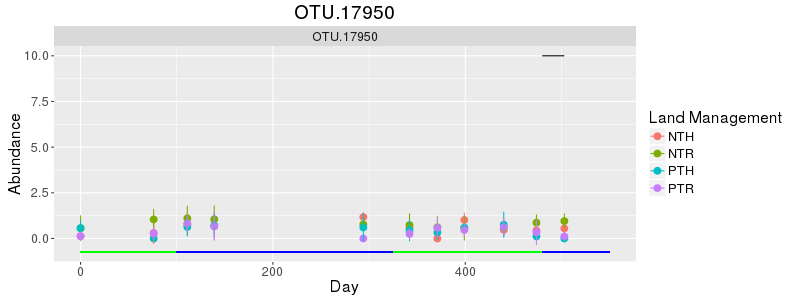

In [47]:
%%R -h 300 -w 800
example = 'OTU.17950'

TS.sig$C = TS.sig$OTU

DF.filt = filter(DF.sum, C %in% example)
TS.filt = filter(TS.sig, C %in% example )

limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = Treat_real)
ggplot(DF.filt, aes(x = time, y = meanab)) + 
geom_point(aes(color = Treat_real), size = 3) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = TS.filt, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) + 
labs(title = example) + theme(text = element_text(size=16)) + ylab('Abundance') + xlab('Day') +
scale_color_discrete(name = "Land Management") + facet_wrap(~C, ncol = 7)+ 
        geom_segment(aes(x=0, xend=100, y=-.75, yend=-.75), color = 'green') +
        geom_segment(aes(x=100, xend=325, y=-.75, yend=-.75), color = 'blue') +
        geom_segment(aes(x=325, xend=480, y=-.75, yend=-.75), color = 'green')+
        geom_segment(aes(x=480, xend=550, y=-.75, yend=-.75), color = 'blue')

In [48]:
%%R
ggsave('data/figs/OTU17950.jpg', width = 10, height = 4)

In [69]:
%%R
filter(TS.sig, OTU == 'OTU.51')

                  X Interval.start Interval.end      Area p.value adjPvalues
1 OTU.51 interval:1              0          503 -1222.408       0          0
     OTU interval num  ISIE      C    Start     End
1 OTU.51 interval   1 0_503 OTU.51 July2014 Nov2015


In [70]:
%%R
head(DF.sum)

Source: local data frame [6 x 6]
Groups: C, time, class [3]

      C  time  class Treat_real   meanab      sdab
  (chr) (int) (fctr)      (chr)    (dbl)     (dbl)
1 OTU.1     0      N        NTH 3.961993 0.6278260
2 OTU.1     0      N        NTR 4.789432 0.5916095
3 OTU.1     0      P        PTH 5.410680 0.5123172
4 OTU.1     0      P        PTR 5.594957 0.6014163
5 OTU.1    76      N        NTH 4.363648 0.2633627
6 OTU.1    76      N        NTR 5.018199 0.4834123


In [71]:
%%R
head(TS.sig)
TS.sig$Start[TS.sig$Interval.start %in% c(0:75)] = 'July2014'
#TS.sig$Start[TS.sig$Interval.start > 0 & TS.sig$Interval.start <76] = 'JunetoSept_2014'
TS.sig$Start[TS.sig$Interval.start %in% c(76:110)] = 'September2014'
#TS.sig$Start[TS.sig$Interval.start > 76 & TS.sig$Interval.start < 111 ] = 'SepttoOct_2014'
TS.sig$Start[TS.sig$Interval.start %in% c(111:138)] = 'October2014'
#TS.sig$Start[TS.sig$Interval.start > 111 & TS.sig$Interval.start < 139 ] = 'Oct_Nov_2014'
TS.sig$Start[TS.sig$Interval.start == 139] = 'November2014'
TS.sig$Start[TS.sig$Interval.start > 139 & TS.sig$Interval.start < 294] = 'Nov2014April2015'
TS.sig$Start[TS.sig$Interval.start %in% c(294:341)] = 'April2015'
#TS.sig$Start[TS.sig$Interval.start > 294 & TS.sig$Interval.start < 342] = 'April_June_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(342: 370)] = 'June2015'
#TS.sig$Start[TS.sig$Interval.start > 342 & TS.sig$Interval.start < 371] = 'June_July_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(371: 398)] = 'July2015'
#TS.sig$Start[TS.sig$Interval.start > 371 & TS.sig$Interval.start < 399] = 'July_Aug_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(399: 439)] = 'August2015'
#TS.sig$Start[TS.sig$Interval.start > 399 & TS.sig$Interval.start < 440] = 'Aug_Sept_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(440: 473)] = 'Sept2015'
#TS.sig$Start[TS.sig$Interval.start > 440 & TS.sig$Interval.start < 474] = 'Sept_Oct_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(474: 502)] = 'Oct2015'
#TS.sig$Start[TS.sig$Interval.start > 474 & TS.sig$Interval.start < 503] = 'Oct_Nov_2015'
TS.sig$Start[TS.sig$Interval.start == 503] = 'Nov2015'


TS.sig$End[TS.sig$Interval.end %in% c(0:75)] = 'July2014'
#TS.sig$End[TS.sig$Interval.end > 0 & TS.sig$Interval.end <76] = 'JunetoSept_2014'
TS.sig$End[TS.sig$Interval.end %in% c(76:110)] = 'September2014'
#TS.sig$End[TS.sig$Interval.end > 76 & TS.sig$Interval.end < 111 ] = 'SepttoOct_2014'
TS.sig$End[TS.sig$Interval.end %in% c(111:138)] = 'October2014'
#TS.sig$End[TS.sig$Interval.end > 111 & TS.sig$Interval.end < 139 ] = 'Oct_Nov_2014'
TS.sig$End[TS.sig$Interval.end == 139] = 'November2014'
TS.sig$End[TS.sig$Interval.end > 139 & TS.sig$Interval.end < 294] = 'Nov2014_April2015'
TS.sig$End[TS.sig$Interval.end %in% c(294:341)] = 'April2015'
#TS.sig$End[TS.sig$Interval.end > 294 & TS.sig$Interval.end < 342] = 'April_June_2015'
TS.sig$End[TS.sig$Interval.end %in% c(342: 370)] = 'June2015'
#TS.sig$End[TS.sig$Interval.end > 342 & TS.sig$Interval.end < 371] = 'June_July_2015'
TS.sig$End[TS.sig$Interval.end %in% c(371: 398)] = 'July2015'
#TS.sig$Start[TS.sig$Interval.end > 371 & TS.sig$Interval.end < 399] = 'July_Aug_2015'
TS.sig$End[TS.sig$Interval.end %in% c(399: 439)] = 'August2015'
#TS.sig$End[TS.sig$Interval.end > 399 & TS.sig$Interval.end < 440] = 'Aug_Sept_2015'
TS.sig$End[TS.sig$Interval.end %in% c(440: 473)] = 'Sept2015'
#TS.sig$End[TS.sig$Interval.end > 440 & TS.sig$Interval.end < 474] = 'Sept_Oct_2015'
TS.sig$End[TS.sig$Interval.end %in% c(474: 502)] = 'Oct2015'
#TS.sig$End[TS.sig$Interval.end > 474 & TS.sig$Interval.end < 503] = 'Oct_Nov_2015'
TS.sig$End[TS.sig$Interval.end == 503] = 'Nov2015'





In [72]:
%%R
Mult_TS = TS.sig %>% group_by(OTU) %>% mutate(TS_num = n()) %>% mutate(diff = Interval.end-Interval.start)

head(Mult_TS) %>% as.data.frame

                    X Interval.start Interval.end       Area p.value adjPvalues
1 OTU.1813 interval:1            140          503 -103.47545       0          0
2  OTU.778 interval:1              0          503 -316.80841       0          0
3 OTU.2343 interval:1              0          503  178.45419       0          0
4 OTU.1809 interval:1            234          503  -67.29953       0          0
5 OTU.2014 interval:1             92          469   73.01350       0          0
6  OTU.598 interval:1             43          503  236.57720       0          0
       OTU interval num    ISIE        C            Start      End TS_num diff
1 OTU.1813 interval   1 140_503 OTU.1813 Nov2014April2015  Nov2015      1  363
2  OTU.778 interval   1   0_503  OTU.778         July2014  Nov2015      1  503
3 OTU.2343 interval   1   0_503 OTU.2343         July2014  Nov2015      1  503
4 OTU.1809 interval   1 234_503 OTU.1809 Nov2014April2015  Nov2015      1  269
5 OTU.2014 interval   1  92_469 OTU.2014    S

In [73]:
%%R
Mult_TS$ISIE = paste(Mult_TS$Start, Mult_TS$End, sep = '-')

In [74]:
%%R
Mult_TS_sum = Mult_TS %>% group_by(ISIE) %>% summarise(counts = n(), max_diff = max(diff), min_diff = min(diff))

In [75]:
%%R
Mult_TS$type = ifelse(Mult_TS$diff > 392, 'Long Term',
                      ifelse(Mult_TS$diff %in% c(210: 392), 'Extended',
                            ifelse(Mult_TS$diff %in% c(103: 209), 'Interannual',
                                ifelse(Mult_TS$diff %in% c(30:102), 'Seasonal',
                                       ifelse(Mult_TS$ISIE %in% c('Nov2014April2015-April2015'), 'Seasonal','Short term')))))

In [76]:
%%R
tax = as.data.frame(tax_table(physeq.Bulk.Sparsity))
tax$OTU = rownames(tax)
head(tax)

             Rank1            Rank2          Rank3                  Rank4 Rank5
OTU.1739  Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
OTU.1813  Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
OTU.778   Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
OTU.2180  Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
OTU.12365 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
OTU.2343  Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
          Rank6 Rank7 Rank8       OTU
OTU.1739   <NA>  <NA>  <NA>  OTU.1739
OTU.1813   <NA>  <NA>  <NA>  OTU.1813
OTU.778    <NA>  <NA>  <NA>   OTU.778
OTU.2180   <NA>  <NA>  <NA>  OTU.2180
OTU.12365  <NA>  <NA>  <NA> OTU.12365
OTU.2343   <NA>  <NA>  <NA>  OTU.2343


In [77]:
%%R
tax$Rank2 = gsub("__", "", tax$Rank2)
tax$Rank3 = gsub("__", "", tax$Rank3)
tax$Rank4 = gsub("__", "", tax$Rank4)
tax$Rank5 = gsub("__", "", tax$Rank5)
tax$Rank6 = gsub("__", "", tax$Rank6)
tax$Rank7 = gsub('__', "", tax$Rank7)

In [78]:
%%R
Mult_TS_tax = left_join(Mult_TS, tax, by = "OTU")

In [79]:
%%R
Mult_TS_tax$Enrich_Status = ifelse(Mult_TS_tax$Area > 0, "Till", "No-Till" )
head(Mult_TS_tax) %>% as.data.frame

                    X Interval.start Interval.end       Area p.value adjPvalues
1 OTU.1813 interval:1            140          503 -103.47545       0          0
2  OTU.778 interval:1              0          503 -316.80841       0          0
3 OTU.2343 interval:1              0          503  178.45419       0          0
4 OTU.1809 interval:1            234          503  -67.29953       0          0
5 OTU.2014 interval:1             92          469   73.01350       0          0
6  OTU.598 interval:1             43          503  236.57720       0          0
       OTU interval num                     ISIE        C            Start
1 OTU.1813 interval   1 Nov2014April2015-Nov2015 OTU.1813 Nov2014April2015
2  OTU.778 interval   1         July2014-Nov2015  OTU.778         July2014
3 OTU.2343 interval   1         July2014-Nov2015 OTU.2343         July2014
4 OTU.1809 interval   1 Nov2014April2015-Nov2015 OTU.1809 Nov2014April2015
5 OTU.2014 interval   1   September2014-Sept2015 OTU.2014    Sept

In [80]:
%%R
sing_resp = filter(Mult_TS_tax, TS_num == 1, adjPvalues < 0.01)
print(length((sing_resp$OTU)))
mult_resp = filter(Mult_TS_tax, TS_num > 1)
print(length(unique(mult_resp$OTU)))


[1] 1486
[1] 27


In [81]:
%%R
sing_resp  %>% group_by(type) %>% filter(Area > 0) %>% summarize(nPT = n()) %>% print()
sing_resp  %>% group_by(type) %>% filter(Area < 0) %>% summarize(nNT = n()) %>% print

Source: local data frame [4 x 2]

         type   nPT
        (chr) (int)
1    Extended    93
2 Interannual    51
3   Long Term   533
4    Seasonal    12
Source: local data frame [5 x 2]

         type   nNT
        (chr) (int)
1    Extended   148
2 Interannual    33
3   Long Term   606
4    Seasonal     9
5  Short term     1


In [82]:
%%R
Mult_TS_sum_type = Mult_TS_tax %>% group_by(type, Rank2, ISIE, Enrich_Status) %>%
        summarise(counts = n(), max_diff = max(diff), min_diff = min(diff))

In [83]:
%%R
cols = c("#417E36",
"#D567D2",
"#58C537",
"#7A79DB",
"#93BB3B",
"#D84891",
"#50D37A",
"#DE4443",
"#3DC1A0",
"#D95821",
"#4DB7D0",
"#E59833",
"#729DDC",
"#C5B432",
"#905D9E",
"#62B264",
"#D64A64",
"#287C76",
"#BB6241",
"#56729D",
"#9C7124",
"#CD93D2",
"#757F26",
"#B95F7D")

In [84]:
%%R
filter(Mult_TS_sum_type, type == 'Short term')

Source: local data frame [1 x 7]
Groups: type, Rank2, ISIE [1]

        type         Rank2            ISIE Enrich_Status counts max_diff
       (chr)         (chr)           (chr)         (chr)  (int)    (int)
1 Short term Acidobacteria Oct2015-Nov2015       No-Till      1       23
Variables not shown: min_diff (int)


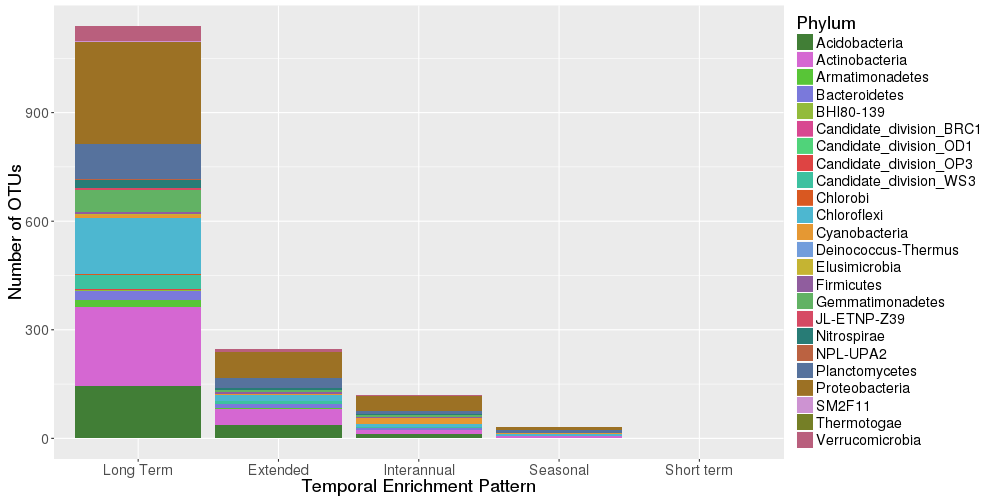

In [120]:
%%R -w 1000 -h 500


Mult_TS_sum_type$type = factor(Mult_TS_sum_type$type, levels = Mult_TS_sum_type$type[order(-Mult_TS_sum_type$counts)])

p = ggplot(data = Mult_TS_sum_type, aes(type, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=18), axis.text.x = element_text(angle=0, vjust=1))  + 
        xlab('Temporal Enrichment Pattern') + ylab('Number of OTUs') + scale_fill_manual(values = cols, name = "Phylum")+
        guides(fill = guide_legend(ncol = 1))

p

In [121]:
%%R
ggsave('data/figs/TemporalEnrichment_Till.png', p, width=10, height=6.5)


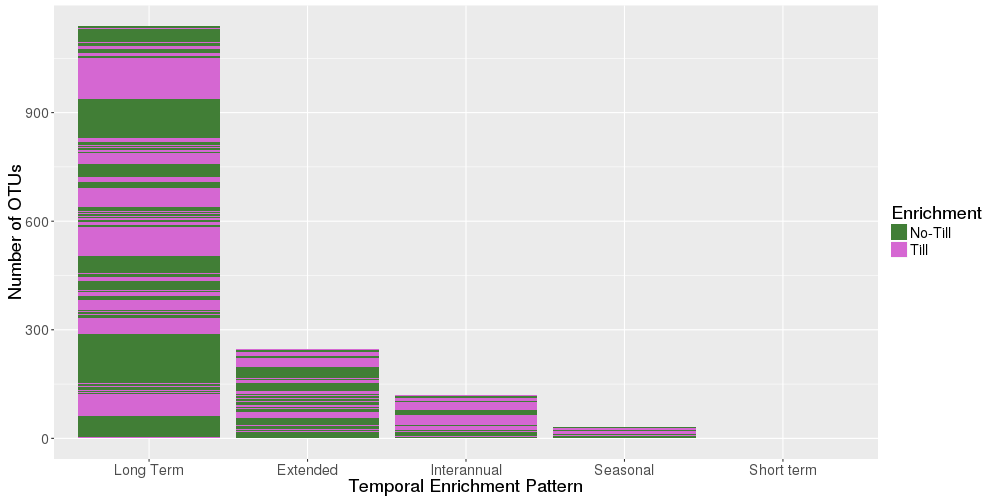

In [86]:
%%R -w 1000 -h 500


Mult_TS_sum_type$type = factor(Mult_TS_sum_type$type, levels = Mult_TS_sum_type$type[order(-Mult_TS_sum_type$counts)])
Mult_TS_sum_type$Enrich_Status = factor(Mult_TS_sum_type$Enrich_Status, levels = Mult_TS_sum_type$Enrich_Status[order(-Mult_TS_sum_type$type)])


p = ggplot(data = Mult_TS_sum_type, aes(type, counts, fill = Enrich_Status)) + geom_bar(stat='identity') +
        theme(text = element_text(size=18), axis.text.x = element_text(angle=0, vjust=1))  + 
        xlab('Temporal Enrichment Pattern') + ylab('Number of OTUs') + scale_fill_manual(values = cols, name = "Enrichment") 

p

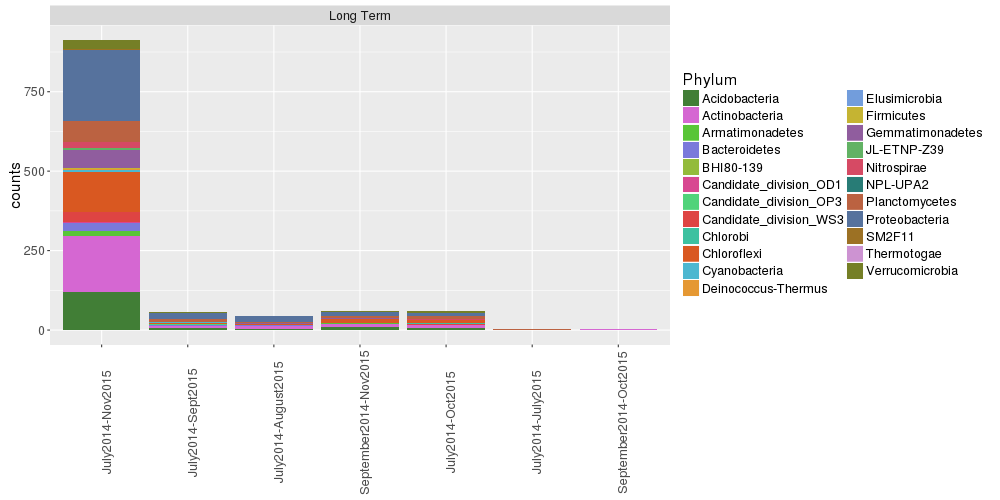

In [87]:
%%R -w 1000 -h 500

Longterm = filter(Mult_TS_sum_type, type == 'Long Term')%>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type) +
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)

p

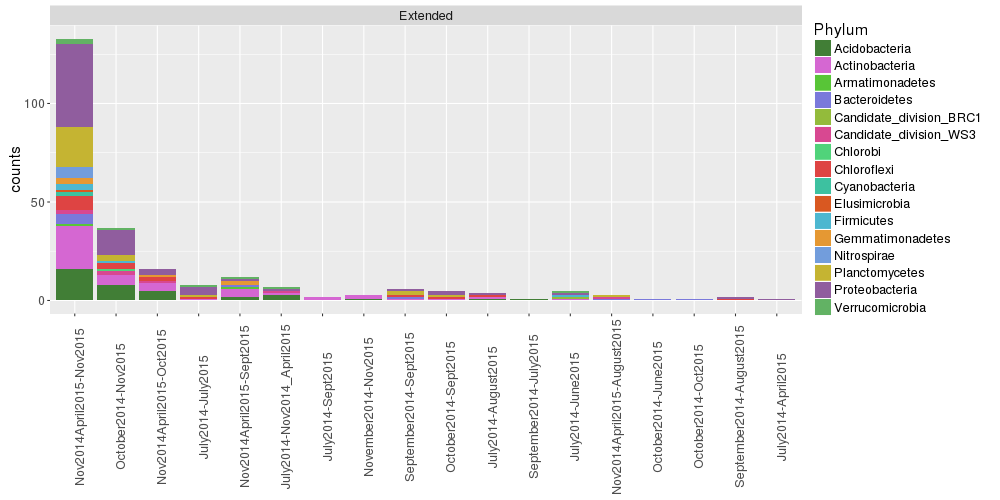

In [88]:
%%R -w 1000 -h 500

Mult_TS_sum_type$ISIE = factor(Mult_TS_sum_type$ISIE, levels = Mult_TS_sum_type$ISIE[order(-Mult_TS_sum_type$counts)])

Longterm = filter(Mult_TS_sum_type, type == 'Extended')  %>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

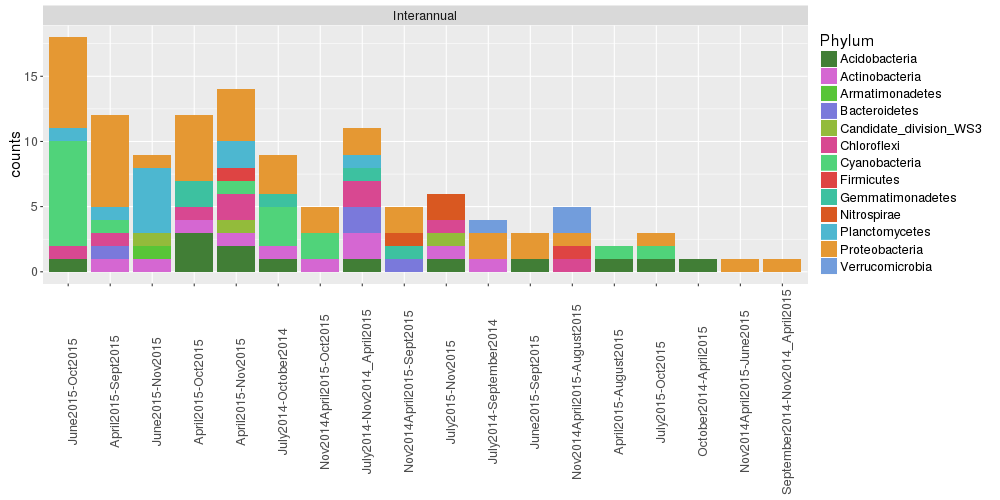

In [89]:
%%R -w 1000 -h 500


Longterm = filter(Mult_TS_sum_type, type == 'Interannual') %>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

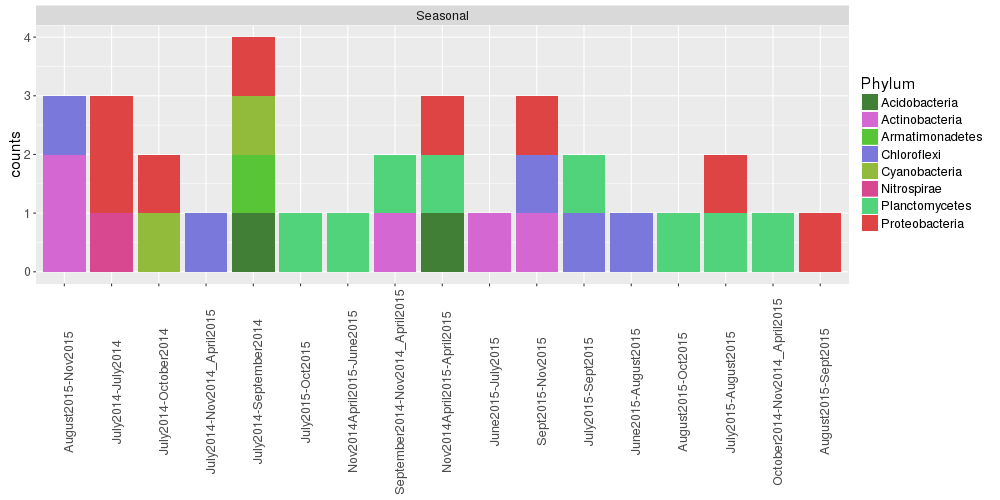

In [90]:
%%R -w 1000 -h 500


Longterm = filter(Mult_TS_sum_type, type == 'Seasonal') %>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

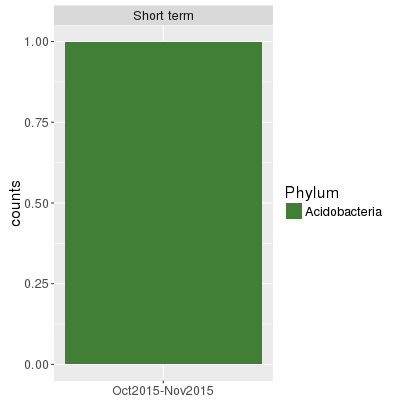

In [91]:
%%R -w 400 -h 400

Mult_TS_sum_type$ISIE = factor(Mult_TS_sum_type$ISIE, levels = Mult_TS_sum_type$ISIE[order(-Mult_TS_sum_type$counts)])

Longterm = filter(Mult_TS_sum_type, type == 'Short term')%>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=0, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

In [92]:
%%R
filter(Mult_TS, ISIE == 'July2014-August2015', type == "Short term") %>% as.data.frame %>% head()

 [1] X              Interval.start Interval.end   Area           p.value       
 [6] adjPvalues     OTU            interval       num            ISIE          
[11] C              Start          End            TS_num         diff          
[16] type          
<0 rows> (or 0-length row.names)


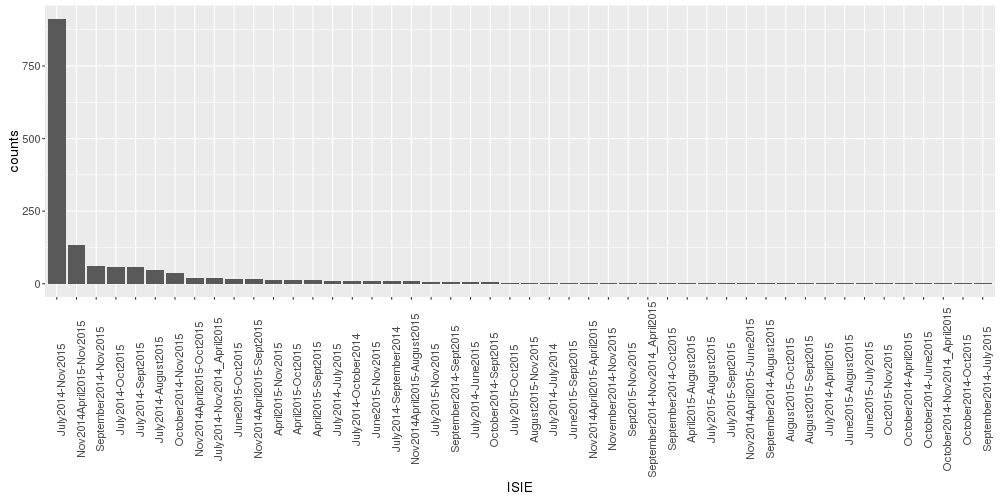

In [93]:
%%R -w 1000 -h 500
Mult_TS_sum$ISIE = factor(Mult_TS_sum$ISIE, levels = Mult_TS_sum$ISIE[order(-Mult_TS_sum$counts)])
p = ggplot(data = Mult_TS_sum, aes(ISIE, counts)) + geom_bar(stat='identity') +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) 

p

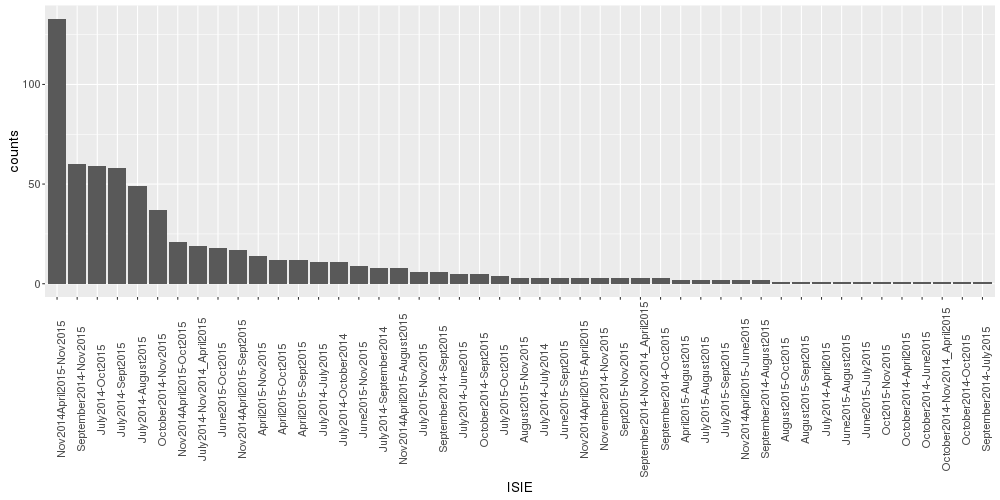

In [94]:
%%R -w 1000 -h 500
Mult_TS_rest = filter(Mult_TS_sum, ISIE != 'July2014-Nov2015')

p = ggplot(data = Mult_TS_rest, aes(ISIE, counts)) + geom_bar(stat='identity') +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) 

p

In [95]:
%%R
sessionInfo()

R version 3.2.4 Revised (2016-03-16 r70336)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu precise (12.04.5 LTS)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] doParallel_1.0.10     iterators_1.0.8       metagenomeSeq_1.11.10
 [4] RColorBrewer_1.1-2    glmnet_2.0-5          foreach_1.4.3        
 [7] Matrix_1.2-6          limma_3.22.7          Biobase_2.30.0       
[10] BiocGenerics_0.16.1   biom_0.3.12           scales_0.4.0         
[13] dplyr_0.4.3           plyr_1.8.3            tidyr_0.4.1          
[16] p